# Competitive learning on the EMNIST database


### Competitive learning
- In competitive learning, the output neurons comptete among themselves to be activated (fire).
- In contrast with the Hebbian learning, here only one neuron (or group of neurons) can be activate at a time.
- The output neuron that wins the competitionis is often called winner-take-all neuron.

### Main steps for compatitive learning implementation:
1. Generate a set of output neurons with random weights.
2. Choose a random input pattern and calculate the activation of each of the output neurons.
3. Detect the winner neuron and update only its weights; the weights of the other neurons are not updated:  , where  is the winner neuron,  is the learning rate and  is the input vector.
4. Repeat from step 2 until the weights are no longer changing, or change less than a set threshold, or a set maximum number of iterations has been reached.

### Some optimisation and tuning methods:
1. Normalised input or initial weights.
2. Noise addition on the weights.
3. Decaying learning rate.
4. Leaky learning: update the weights of the losers as well as winners but with a much smaller learning rate.
5. Update the winners and neighbouring losers.

In [1]:
# Import the required modules
import numpy as np
import numpy.matlib
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings        # ignore the warning from jupyter notebook stopping the computation
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
import pandas as pd
import seaborn as sns 

#### Load the data set

In [2]:
# We do not need the labels as we are not using unsupervised learning approach
train = np.genfromtxt ('letters.csv', delimiter=",")
[n,m]  = np.shape(train)         # number of pixels (input neurons) and number of training data

#### Base

1.0


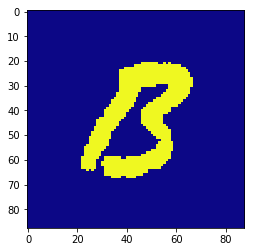

In [3]:
# Normalise the dataset
normT = np.sqrt(np.diag(train.T.dot(train)))
train = train / np.matlib.repmat(normT.T,n,1)
data = train.T

print(numpy.linalg.norm(data[1,:]))     # Check the normalisation is correct
                                        # If the value is 1.0 or 0.9999, normalisation is correct

# Check the normalisation success and show one of example from trained data
pix = int(math.sqrt(n))
image = np.reshape(train[:,3],(pix,pix),order="F")
plt.imshow(image, cmap = 'plasma');

#### Parameters and variables

In [4]:
eta    = 0.05                                                    # initial learning rate
etf    = 0.005                                                   # final learning rate
alpha = 0.999
dead = 0                                                         # number of dead cells

tmax   = 5000                                                    # number of iteration
digits = 20                                                      # number of prototypes to show (output neurons)

corr_matrix = np.zeros((digits,digits))                          # Create empty correlation matrix
threshold = 0.35                                                 # Threshold for correlation matrix


# Activate techniques. on = activated, off = deactivate
tech_weight = 'off'
tech_noise = 'off'
tech_decay = 'off'
tech_update = 'off'

if tech_weight != 'on':
    # weight initialised randomly (base)
    W = np.random.rand(digits,n)                                 # Weight matrix (rows = output neurons, cols = input neurons)
elif tech_weight == 'on':
    # weight initialised from randomly selected sample of dataset (tech_weight)
    indices = np.arange(data.shape[0])
    selected = np.random.choice(indices,digits)                  # choose 'digit' amount of random indices
    W = data[selected]

# Normalise the weight vectors
normW = np.sqrt(np.diag(W.dot(W.T))).reshape(digits,-1)          # reshape normW into a numpy 2d array

W = W / np.matlib.repmat(normW.T,n,1).T                          # normalise using repmat

print(numpy.linalg.norm(W[1,:]))

counter = np.zeros((1,digits))                                   # counter for the winner neurons
wCount = np.ones((1,tmax+1)) * 0.25                              # running average of the weight change over time

1.0


####  Implementation, learning and output

In [5]:
for t in range(1,tmax):
    i = math.ceil(m * np.random.rand())-1                                 # get a randomly generated index in the input range
    x = train[:,i]                                                        # pick a training instance using the random index

    h = W.dot(x)/digits                                                   # get output firing
    h = h.reshape(h.shape[0],-1)                                          # reshape h into a numpy 2d array

    if tech_noise == 'on':
        xi = np.random.rand(digits,1) / 200                               # generate random number which is noise (tech_noise)
        h = h + xi                                                        # add noise with h
        
    k = np.argmax(h)                                                      # get the index of the firing neuron  
    
    counter[0,k] += 1                                                     # increment counter for winner neuron
    
    et = eta * (etf/eta)**(t/tmax)                                        # exponential decaying learning rate by each iteration (tech_decay)
                                                                          # sourced by: https://pdfs.semanticscholar.org/7f13/a0c932e32eb0dbe009dc86badfe8bed31e66.pdf

    if tech_decay == 'on':
        dw = et * (x.T - W[k,:])                                          # calculate the change in weights for the k-th output neuron
                                                                          # get closer to the input (x - W)
    elif tech_decay == 'off':
        dw = eta * (x.T - W[k,:])

    wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha))        # % weight change over time (running average)

    
    W[k,:] = W[k,:] + dw                                                  # update weights for k-th output
    
    if tech_update == 'on':
        W = W + (dw*0.0005)                                               # update weights for surrounding losers(tech_update)
        

####  Grids of prototypes

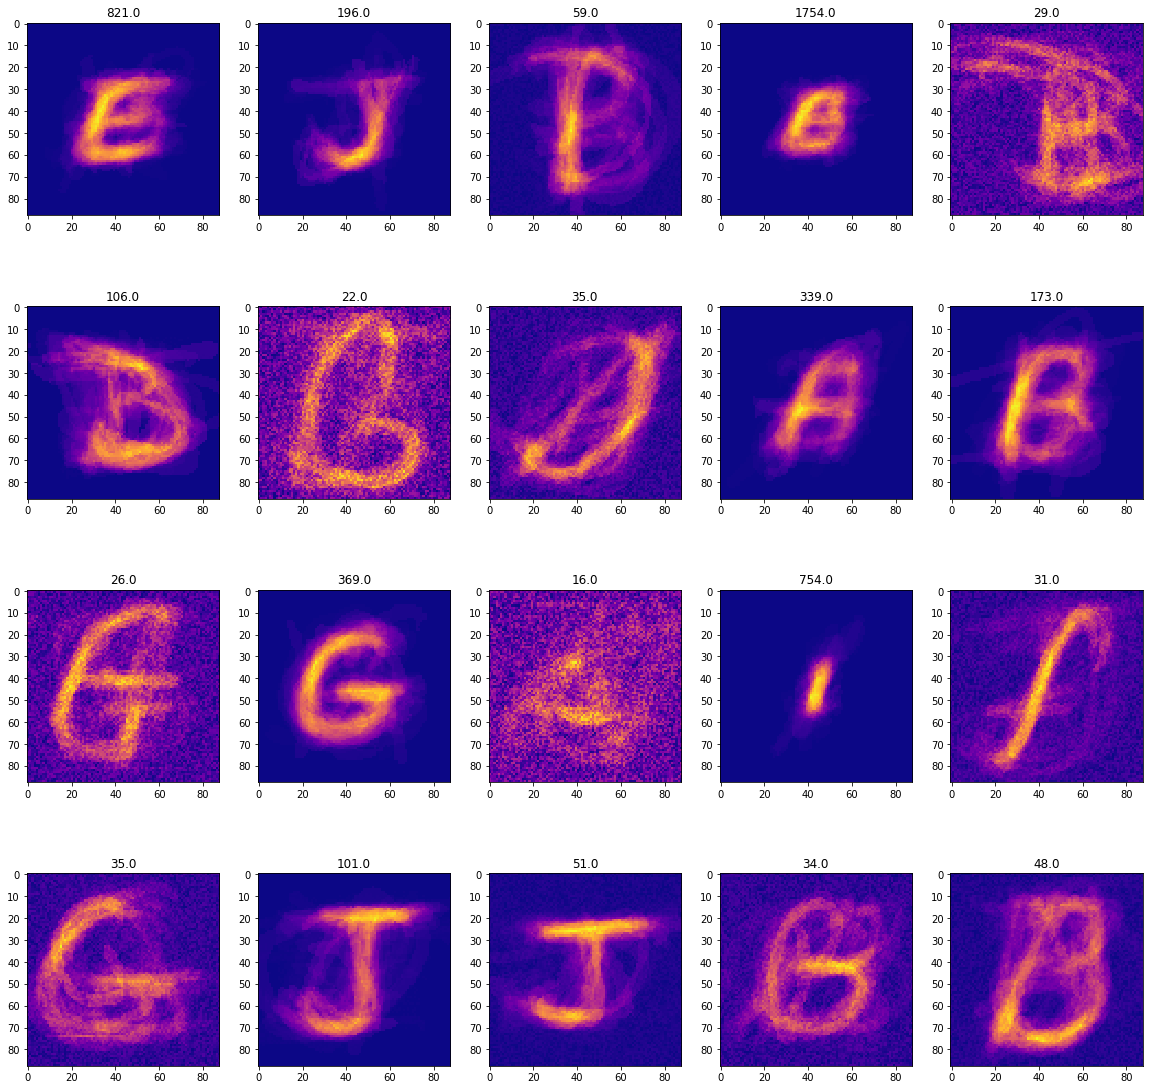

In [6]:
# Plot a prototypes in grid
fig = plt.figure(figsize=(20,20))             # size of figure
columns = 5                                   # number of columns
rows = int(round(digits/5))                   # counter for the rows of the subplot
if digits % 5 != 0:                           # number of rows
    rows += 1

for y in range(digits):
    fig.add_subplot(rows, columns, y+1).set_title(counter[0,y])
    plt.imshow(W[y,:].reshape((88,88), order = 'F'),interpolation = 'nearest', cmap='plasma')
 


####  Count number of dead cells

In [7]:
#Number of dead cells
for j in counter[0,:]:
    if j < 50:
        dead += 1
        
print(dead)

9


####  Display changing weight over time

Text(0, 0.5, 'weights')

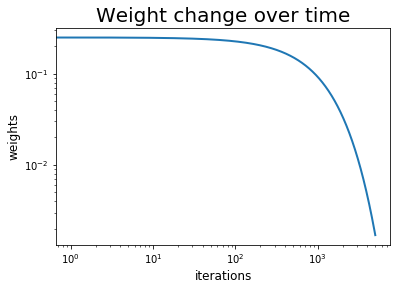

In [8]:
# Plot running average in log-log
plt.plot(wCount[0,0:tmax], linewidth=2.0, label='rate')
plt.yscale('log')
plt.xscale('log')
plt.title('Weight change over time', fontsize=20)
plt.xlabel('iterations', fontsize=12)
plt.ylabel('weights', fontsize=12)

####  Correlation Matrix

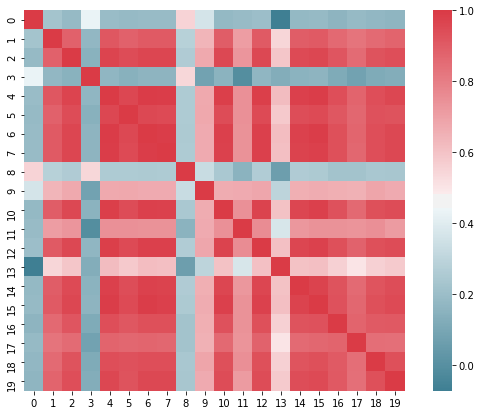

In [9]:
for i in data:
    output = np.dot(W, i)                       # Get firings of neurons
    shape = np.zeros_like(output)
    shape[output <= threshold] = -1             # If equal or less than threshold, set as -1
    shape[output > threshold] = 1               # If above threshold, set as 1
    
    corr_matrix += np.outer(shape, shape)       # Added to empty correlation matrix
    
corr_matrix /= data.shape[0]                    # Sum of divided by 

f, ax = plt.subplots(figsize=(10, 7))

# Plot correlation matrix
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)